In [14]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
import torch
import random

seed = 10
torch.manual_seed(seed)
random.seed(seed)


### Custom Dataset storing Sum of MNIST

Total number of digit for summation is 3


In [2]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class SumMNISTDataset(Dataset):
    def __init__(self, root="", train=True, size=84000, zeros=1000):
        path = os.path.join(root, "train" if train else "test")
        image_file, label_file = os.listdir(path)
        image_path = os.path.join(path, image_file)
        label_path = os.path.join(path, label_file)

        images = load_images(image_path)
        labels = load_labels(label_path)

        add_blank(images, labels, zeros)
        dataset, self.images, self.labels = sum_dataset(images, labels, size, 3)

        label_unique, frequency = np.unique(self.labels, return_counts=True)
        for i, label in enumerate(label_unique):
            print(f"{label}: {frequency[i]}")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        image = torch.tensor(image, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [3]:
train_dataset = SumMNISTDataset(root="mnist", train=True, size=60000, zeros=6000)
test_dataset = SumMNISTDataset(root="mnist", train=True, size=10000, zeros=1000)

0: 2142
1: 2142
2: 2142
3: 2140
4: 2130
5: 2142
6: 2128
7: 2124
8: 2115
9: 2090
10: 2142
11: 2139
12: 2117
13: 2100
14: 2100
15: 2117
16: 2139
17: 2142
18: 2090
19: 2115
20: 2124
21: 2128
22: 2142
23: 2130
24: 2140
25: 2142
26: 2142
27: 2142
0: 357
1: 357
2: 354
3: 350
4: 345
5: 357
6: 336
7: 324
8: 315
9: 330
10: 315
11: 345
12: 292
13: 300
14: 300
15: 292
16: 345
17: 315
18: 330
19: 315
20: 324
21: 336
22: 357
23: 345
24: 350
25: 354
26: 357
27: 357


### Visualizing the Dataset


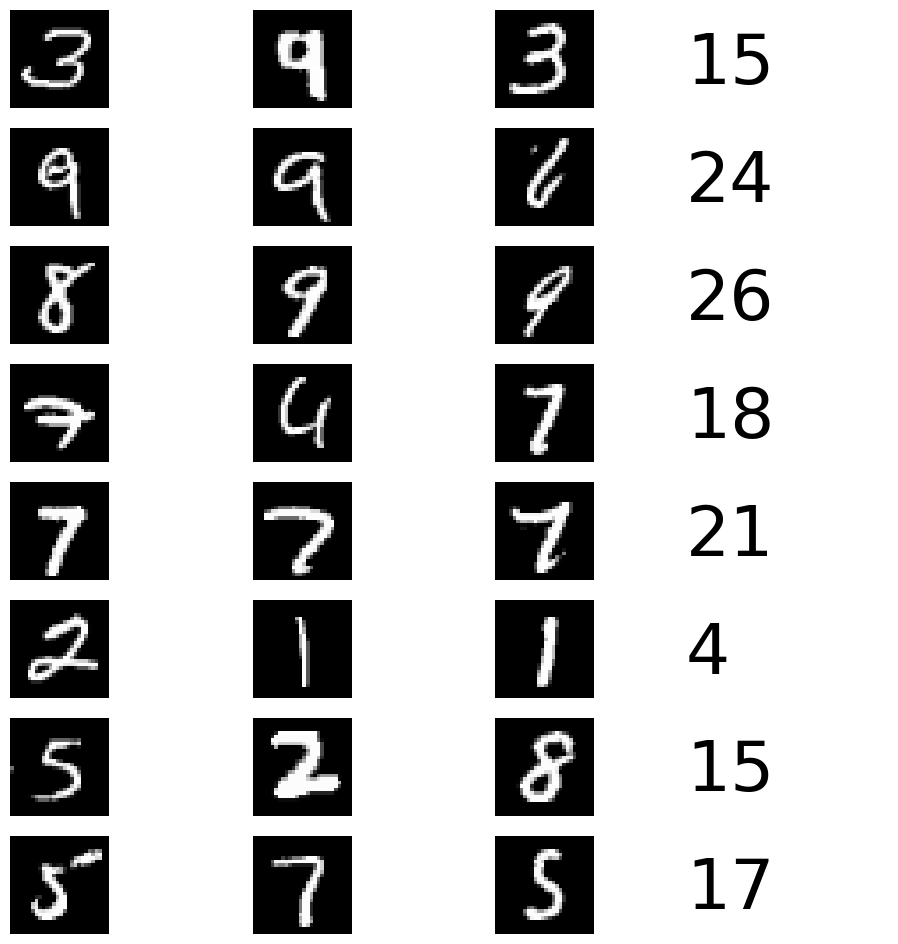

In [4]:
fig, axes = plt.subplots(8, 4, figsize=(12, 12))
random_indices = np.random.choice(len(train_dataset), 10)

for i in range(len(axes)):
    image_t, label_t = train_dataset[random_indices[i]]
    row_len = len(axes[i])
    for j in range(row_len - 1):
        axes[i][j].imshow(image_t[j], cmap="gray")
        axes[i][j].axis("off")

    axes[i][row_len - 1].text(0, 0.25, f"{label_t.item()}", fontsize=50)
    axes[i][row_len - 1].axis("off")

### Build the Model


In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

print(f"Using {device}")

Using cuda


In [6]:
from torch import nn
from torch import optim


class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            #
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.dense_layer = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(in_features=5 * 5 * 32, out_features=500),
            nn.ReLU(),
            #
            nn.Linear(in_features=500, out_features=100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            #
            nn.Linear(in_features=100, out_features=28),
            nn.Softmax(dim=1),
        )

        # self.flatten = nn.Flatten()
        # self.convolutional_layer = nn.Sequential(
        #     nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     #
        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        # self.dense_layer = nn.Sequential(
        #     nn.Dropout(0.25),
        #     nn.Linear(in_features=5 * 5 * 32, out_features=500),
        #     nn.ReLU(),
        #     #
        #     nn.Linear(in_features=500, out_features=100),
        #     nn.ReLU(),
        #     #
        #     nn.Linear(in_features=100, out_features=28),
        #     nn.Softmax(dim=1),
        # )

    def forward(self, x):
        x = self.convolutional_layer(x)
        x = self.flatten(x)
        x = self.dense_layer(x)

        return x


model = ConvolutionalNeuralNetwork().to(device)

In [7]:
train_cost = []
test_cost = []


def train_model(model, dataloader, loss_function, optimizer, scheduler):
    model.train()
    correct = 0
    cost = 0

    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)

        loss = loss_function(y_pred, y)

        cost += loss.item()
        correct += torch.sum(torch.eq(torch.argmax(y_pred, dim=1), y)).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 320 == 0:
        #     print(
        #         f"Loss: {loss :>7f} [{(batch + 1) * len(x)}/{len(dataloader.dataset)}]"
        #     )

    data_size = len(dataloader.dataset)
    cost /= data_size
    scheduler.step(cost)
    correct /= data_size
    train_cost.append(cost)

    print(f"Train accuracy: {correct * 100 :<0.1f}%, Train cost: {cost :<8f}")


def test_model(model, dataloader, loss_function):
    model.eval()
    correct = 0
    cost = 0

    for batch, (x, y) in enumerate(dataloader):
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)

        loss = loss_function(y_pred, y)

        cost += loss.item()
        correct += torch.sum(torch.eq(torch.argmax(y_pred, dim=1), y)).item()

    data_size = len(dataloader.dataset)
    cost /= data_size
    correct /= data_size
    test_cost.append(cost)

    print(f"Test accuracy: {correct * 100 :<0.1f}%, Test cost: {cost :<8f}")

In [8]:
optimizer = optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.2, patience=3
)

batch_size = 128


train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


epoch_size = 100

for epoch in range(epoch_size):
    print(
        f"--------------------------------------------- Epoch {epoch + 1} ---------------------------------------------"
    )

    train_model(model, train_dataloader, loss_function, optimizer, scheduler)

    test_model(model, test_dataloader, loss_function)

--------------------------------------------- Epoch 1 ---------------------------------------------
Train accuracy: 21.2%, Train cost: 0.024875
Test accuracy: 30.3%, Test cost: 0.024597
--------------------------------------------- Epoch 2 ---------------------------------------------
Train accuracy: 34.9%, Train cost: 0.023899
Test accuracy: 38.9%, Test cost: 0.023897
--------------------------------------------- Epoch 3 ---------------------------------------------
Train accuracy: 42.0%, Train cost: 0.023366
Test accuracy: 45.1%, Test cost: 0.023433
--------------------------------------------- Epoch 4 ---------------------------------------------
Train accuracy: 46.4%, Train cost: 0.023026
Test accuracy: 48.5%, Test cost: 0.023076
--------------------------------------------- Epoch 5 ---------------------------------------------
Train accuracy: 49.7%, Train cost: 0.022765
Test accuracy: 51.1%, Test cost: 0.022923
--------------------------------------------- Epoch 6 ----------------

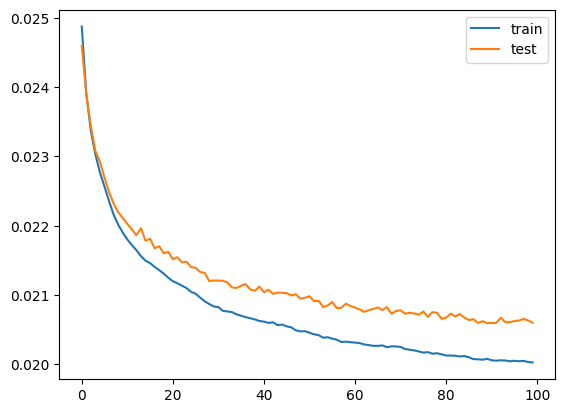

In [9]:
# 29.6%
# batch_size = 64
# lr = 0.0001
# weight_decay = 0.0001
plt.plot(train_cost, label="train")
plt.plot(test_cost, label="test")
plt.legend()

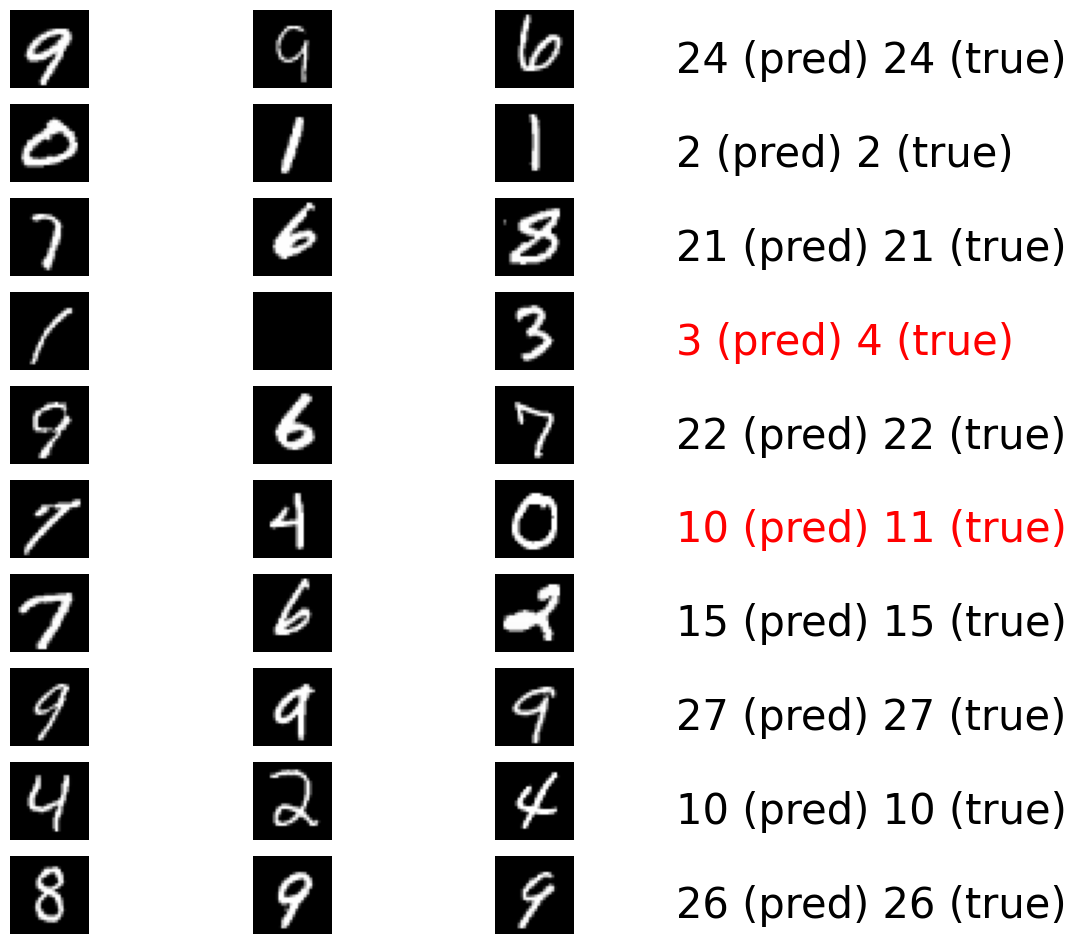

In [13]:
fig, axes = plt.subplots(10, 4, figsize=(12, 12))
random_indices = np.random.choice(len(test_dataloader.dataset), 10)
x, y = next(iter(test_dataloader))
y_pred = model(x.to(device)).argmax(dim=1)

for i in range(len(axes)):
    images = x[i]

    row_len = len(axes[i])
    for j in range(row_len - 1):
        axes[i][j].imshow(images[j], cmap="gray")
        axes[i][j].axis("off")

    color = "red" if y_pred[i] != y[i] else "black"
    axes[i][row_len - 1].text(
        0, 0.2, f"{y_pred[i]} (pred) {y[i]} (true)", fontsize=30, color=color
    )
    axes[i][row_len - 1].axis("off")

### Save the Model


In [11]:
# torch.save(
#     {
#         "epoch": epoch,
#         "batch_size": batch_size,
#         "model_state_dict": model.state_dict(),
#         "optimizer_state_dict": optimizer.state_dict(),
#         "loss": loss_function,
#         "seed": seed,
#     },
#     r"model\without_zero_best",
# )